In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

# Set sklearn output to pandas dataframes
from sklearn import set_config
set_config(transform_output='pandas')

In [4]:
import optuna
import logging
import warnings

import warnings
warnings.filterwarnings('ignore', category=optuna.exceptions.ExperimentalWarning)

logger = logging.getLogger()

logger.setLevel(logging.INFO)  # Setup the root logger.
logger.addHandler(logging.FileHandler("./cache/optuna.log", mode="w"))

optuna.logging.enable_propagation()  # Propagate logs to the root logger.
optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

base_path = './prod/pca'

def get_study(name):
    # create or load the study
    study = optuna.study.create_study(
        storage=f'sqlite:///{base_path}/cache/optuna.db',
        load_if_exists=True,
        directions=['maximize', 'minimize'],
        study_name=name,
        sampler=optuna.samplers.TPESampler(n_startup_trials=30),
        pruner=optuna.pruners.MedianPruner()
    )
    study.set_metric_names(['r2', 'mse'])
    return study


/home/marco/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read the data

In [5]:
from src.selectvar import get_data

data, variables = get_data(window=7)

data = data[(data['pmonin'] <= 9) & (data['pmonin'] >= 5)]

# Preprocessing

In [6]:
def remove_duplicate_prefixes(strings):
    selected_strings = []
    removed_strings = []
    seen_prefixes = set()
    for string in strings:
        prefix = string.split('_')[0]
        if prefix not in seen_prefixes:
            seen_prefixes.add(prefix)
            selected_strings.append(string)
        else:
            removed_strings.append(string)
    return removed_strings

def get_category(cat):
    return variables.loc['category', variables.loc['category',:] == cat].index.tolist()


# Manuall dropping of variables (very clear cases)
columns_to_drop = [
    'fweight', 'fheight', 'valid', # imputation flags
    'pcs', 'mcs', #pca of other variables
    'plj0151'
]
columns_to_drop += get_category('key')
columns_to_drop += remove_duplicate_prefixes(data.columns)

data.drop(columns=columns_to_drop, inplace=True)
variables.drop(columns=columns_to_drop, inplace=True)

# drop nans
data[data<0] = np.nan
data.dropna(inplace=True)

# get weather data
weather = data[['prcp', 'tsun', 'wspd', 'pres', 'tavg']].copy()

data.drop(columns=['prcp', 'tsun', 'wspd', 'pres', 'tavg'], inplace=True)
variables.drop(columns=['prcp', 'tsun', 'wspd', 'pres', 'tavg'], inplace=True)

# get target
variables.drop(columns='plh0182', inplace=True)
y = data.pop('plh0182')

print(f'There are {data.shape[0]} rows remaining in the data')

There are 25002 rows remaining in the data


In [7]:
from sklearn.decomposition import PCA

# do pca transform for all categories
pca_transformed = []
for category in tqdm(variables.loc['category',:].unique()):
    # Get subset of data in that category
    vars = get_category(category)
    subset = data.loc[:, vars].copy()
    subset_vars = variables.loc[:, vars].copy()

    # Get all nominal variables to create dummies
    cat_vars = subset_vars.loc['type', subset_vars.loc['type',:] == 'Nominal'].index.tolist()
    dummies = subset.loc[:, cat_vars].copy()
    # Remove the variables temporarily
    subset.drop(columns=cat_vars, inplace=True)
    subset_vars.drop(columns=cat_vars, inplace=True)
    # Add variables back as dummies
    for var in cat_vars:
        card = len(dummies[var].unique())
        if card >= 20:
            continue
        subset = pd.concat([subset, pd.get_dummies(dummies[var], sparse=False, drop_first=True, prefix=var)], axis=1)

    # Perform PCA on variable
    pca = PCA()
    pca = pca.fit(subset)
    pca_transformed.append((category, pca, subset))

100%|██████████| 7/7 [00:00<00:00, 27.63it/s]


In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

make_pl = lambda: Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=4))]) 

data_complete = pd.DataFrame()
without_weather_args = []
transformer_args = []
for category, _, X in pca_transformed:
    data_complete = pd.concat([data_complete, X], axis=1)
    pl = make_pl()
    without_weather_args.append((category, pl, X.columns.tolist()))
    transformer_args.append((category, pl, X.columns.tolist()))
    
# add the weather data
pl = Pipeline(
    steps=[
        ('standard scaler'), StandardScaler()
    ]
)

# Add weather data
X = pd.concat([data_complete, weather], axis=1)

# Create transformation pipelines
transformer_args.append(('Weather', StandardScaler(), weather.columns))

In [9]:
from sklearn.compose import ColumnTransformer

# Create transformers
transformer = ColumnTransformer(
    transformers=transformer_args
)

# Transform data
transformer.fit(X)
X = transformer.fit_transform(X)

In [10]:
# Bootstrapping
from src.selectvar import BootstrapSampler
custom_cv = BootstrapSampler(n_sample_test=30_000, n_sample_train=40_000, n_test=3/4, n_bootstraps=4)

In [11]:
from sklearn.ensemble import HistGradientBoostingRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error
from keras.regularizers import l1_l2
import tensorflow as tf

# Objective function for hp tuning
def objective(trial, est, suggestor):
    # suggest params
    params = suggestor(trial)
    est.set_params(**params)
    # suggest number of principle components
    r2_scores, mse_scores = [], []
    for train_idx, test_idx in custom_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        # fit estimator
        est = est.fit(X_train, y_train)
        # predict test set
        y_pred = est.predict(X_test)
        y_true = y_test
        # compute the performance
        r2_scores.append(r2_score(y_true, y_pred))
        mse_scores.append(mean_squared_error(y_true, y_pred))
    return np.mean(r2_scores), np.mean(mse_scores)

############################
############################

# Suggesting functions for each model
def hb_suggestor(t):
    t.suggest_int('max_iter', 1, 1001, 10)
    t.suggest_int('max_depth', 3, 20, 1)
    t.suggest_int('min_samples_leaf', 10, 400, step=10)
    t.suggest_float('l2_regularization', 0.001, 100, log=True)
    return t.params

def sgd_suggestor(t):
    t.suggest_float('alpha', 1e-4, 1e-1, log=True)
    t.suggest_float('epsilon', 1e-2, 0.1)
    t.suggest_categorical('loss', ['squared_epsilon_insensitive', 'epsilon_insensitive', 'squared_error', 'huber'])
    t.suggest_categorical('penalty', ["l2", "l1", "elasticnet"])
    return t.params

# define a function that returns a Keras model
def create_model(n_input, n_hidden=1, units=None, activation='relu', l1=0.01, l2=0.01, dropout_rate=0.1):
    model = tf.keras.models.Sequential()
    if units is None:
        units = [10] * n_hidden
    model.add(tf.keras.layers.Dense(units[0], input_dim=n_input, activation=activation, kernel_regularizer=l1_l2(l1=l1, l2=l2)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    for i in range(0, n_hidden):
        model.add(tf.keras.layers.Dense(units[i], activation=activation, kernel_regularizer=l1_l2(l1=l1, l2=l2)))
        model.add(tf.keras.layers.Dropout(dropout_rate))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

def mlp_suggestor(t):
    n_layers = t.suggest_int('n_hidden', 1, 2)
    units = [t.suggest_int(f'n_units_{i}', 1, 200) for i in range(n_layers)]
    learning_rate = t.suggest_float('optimizer__learning_rate', 1e-4, 1e-2)
    l1 = t.suggest_float("l1", 1e-5, 1e-1, log=True)
    l2 = t.suggest_float("l2", 1e-5, 1e-1, log=True)
    dropout_rate = t.suggest_float("dropout_rate", 0.1, 0.5)
    activation = t.suggest_categorical('activation', ['relu'])
    batch_size = t.suggest_int('batch_size', 100, 2000, 20)
    return {
        'n_hidden': n_layers,
        'units': units,
        'activation': activation,
        'optimizer__learning_rate': learning_rate,
        'batch_size': batch_size,
        'l1': l1,
        'l2': l2,
        'dropout_rate': dropout_rate
    }

############################
############################

# Define the models to optimize
hb = HistGradientBoostingRegressor(
    learning_rate=0.01, early_stopping=True
)

sgd = SGDRegressor(max_iter=20_000)

mlp = KerasRegressor(
    model=create_model,
    n_input=X.shape[1],
    n_hidden=1, units=None, activation='relu',
    epochs=100, batch_size=300, verbose=0,
    l1=0.01, l2=0.01, dropout_rate=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping],
    callbacks__patience=10,
    callbacks__monitor="loss"
)

models = [
    ('Multilayer Perceptron', mlp, mlp_suggestor),
    ('Hist Gradient Boosting Regressor', hb, hb_suggestor),
    ('Stochastic Gradient Descent', sgd, sgd_suggestor)
]

for name, model, func in models:
    study = get_study(name)
    study.optimize(lambda x: objective(x, model, func), timeout=60*60, n_trials=0)


2023-08-26 13:02:45.267690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 13:02:45.343044: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [12]:
# Set best parameters
mlp_best_param = {
    'activation':'relu',
    'batch_size':1900,
    'dropout_rate':0.37400972123690973,
    'l1':1.2797887226305642e-05,
    'l2':9.418334838632396e-05,
    'units':[51],
    'optimizer__learning_rate':0.0021473683256983296,
}
mlp.set_params(**mlp_best_param)

hb_best_param = {
    'l2_regularization':0.08626650218508464,
    'max_depth':18,
    'max_iter':941,
    'min_samples_leaf':90
}
hb.set_params(**hb_best_param)

sgd_best_param = {
    'alpha':0.0004169930220027629,
    'epsilon':0.08962987758165605,
    'loss':'squared_error',
    'penalty':'l1'
}
sgd.set_params(**sgd_best_param)

SGDRegressor(alpha=0.0004169930220027629, epsilon=0.08962987758165605,
             max_iter=20000, penalty='l1')

In [13]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold

# make a bootstrap sampler
n_splits = 10
custom_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Create an empty dataframe to store the results
score_result_df = pd.DataFrame()
importance_df = pd.DataFrame()

# Iterate over the bootstraps
for train_idx, test_idx in tqdm(custom_cv.split(X, y), total=n_splits):
    # Get train part of bootstrap
    X_train_b = X.iloc[train_idx]
    y_train_b = y.iloc[train_idx]
    X_test_b = X.iloc[test_idx]
    y_test_b = y.iloc[test_idx]

    for name, model, func in models:
        # train all models
        model.fit(X_train_b, y_train_b)

        # Check how well the model is performing
        y_test_pred = model.predict(X_test_b)
        y_train_pred = model.predict(X_train_b)

        # Calculate R2
        score_test = r2_score(y_test_b, y_test_pred)
        score_train = r2_score(y_train_b, y_train_pred)
        # Calculate Mean Squared Error (MSE)
        mse_test = mean_squared_error(y_test_b, y_test_pred)
        mse_train = mean_squared_error(y_train_b, y_train_pred)

        # Save
        score_result_df = pd.concat(
            [score_result_df, pd.DataFrame({
                'r2': [score_test, score_train], 
                'mse':[mse_test, mse_train],
                'test': [True, False], 
                'model':[name, name]
            })], 
            axis=0
        )

        # Perform permutation importance
        result = permutation_importance(
            model, X_test_b, y_test_b, scoring='r2', n_repeats=1
        )
        temp = pd.DataFrame({
            'features': X_train_b.columns,
            'importance_mean': result['importances_mean'],
            'importance_std': result['importances_std'],
            'model':name
        })
        importance_df = pd.concat([importance_df, temp], axis=0)


# Save dataframes
score_result_df.to_csv(f"{base_path}/tables/score_results.csv", index=False)
importance_df.to_csv(f"{base_path}/tables/importance_results.csv", index=False)

  0%|          | 0/10 [00:00<?, ?it/s]2023-08-26 13:02:48.976482: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-26 13:02:48.976510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marco-aspire7): /proc/driver/nvidia/version does not exist
2023-08-26 13:02:48.977016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
  0%|          | 0/10 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [14]:
from sklearn.inspection import partial_dependence
from sklearn.model_selection import StratifiedKFold

# compute interaction between Health_pca0 and Weather_tavg
n_splits = 10
custom_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Create an empty list to store the results
#partial_dependence_results = []
df_results = pd.DataFrame(columns=["model_name", "feature_value", "partial_dependence"])

# Iterate over the bootstraps
for train_idx, test_idx in tqdm(custom_cv.split(X, y), total=n_splits):
    # Get train part of bootstrap
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]

    for name, model, _ in models:
        # Fit the model
        model.fit(X_train, y_train)

        # Compute the partial dependence
        #pdp_result_1 = partial_dependence(model, X_train_b, ['Health Status__pca1', 'Weather__tavg'], kind='average', method='brute', grid_resolution=20)
        #pdp_result_2 = partial_dependence(model, X_train_b, ['Health Status__pca0', 'Weather__tavg'], kind='average', method='brute', grid_resolution=20)

        # Append to the overall results
        #partial_dependence_results.append((name, pdp_result_1, pdp_result_2))
        results = partial_dependence(model, X_test, 'Weather__tavg', kind='average', method='brute', grid_resolution=20)
        # Add each result to the list
        df_temp = pd.DataFrame({"model": name, 
                                "average": results['average'].squeeze(), 
                                "values": results['values'][0]})
        # append to the results DataFrame
        df_results = pd.concat([df_results, df_temp], axis=0)


100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


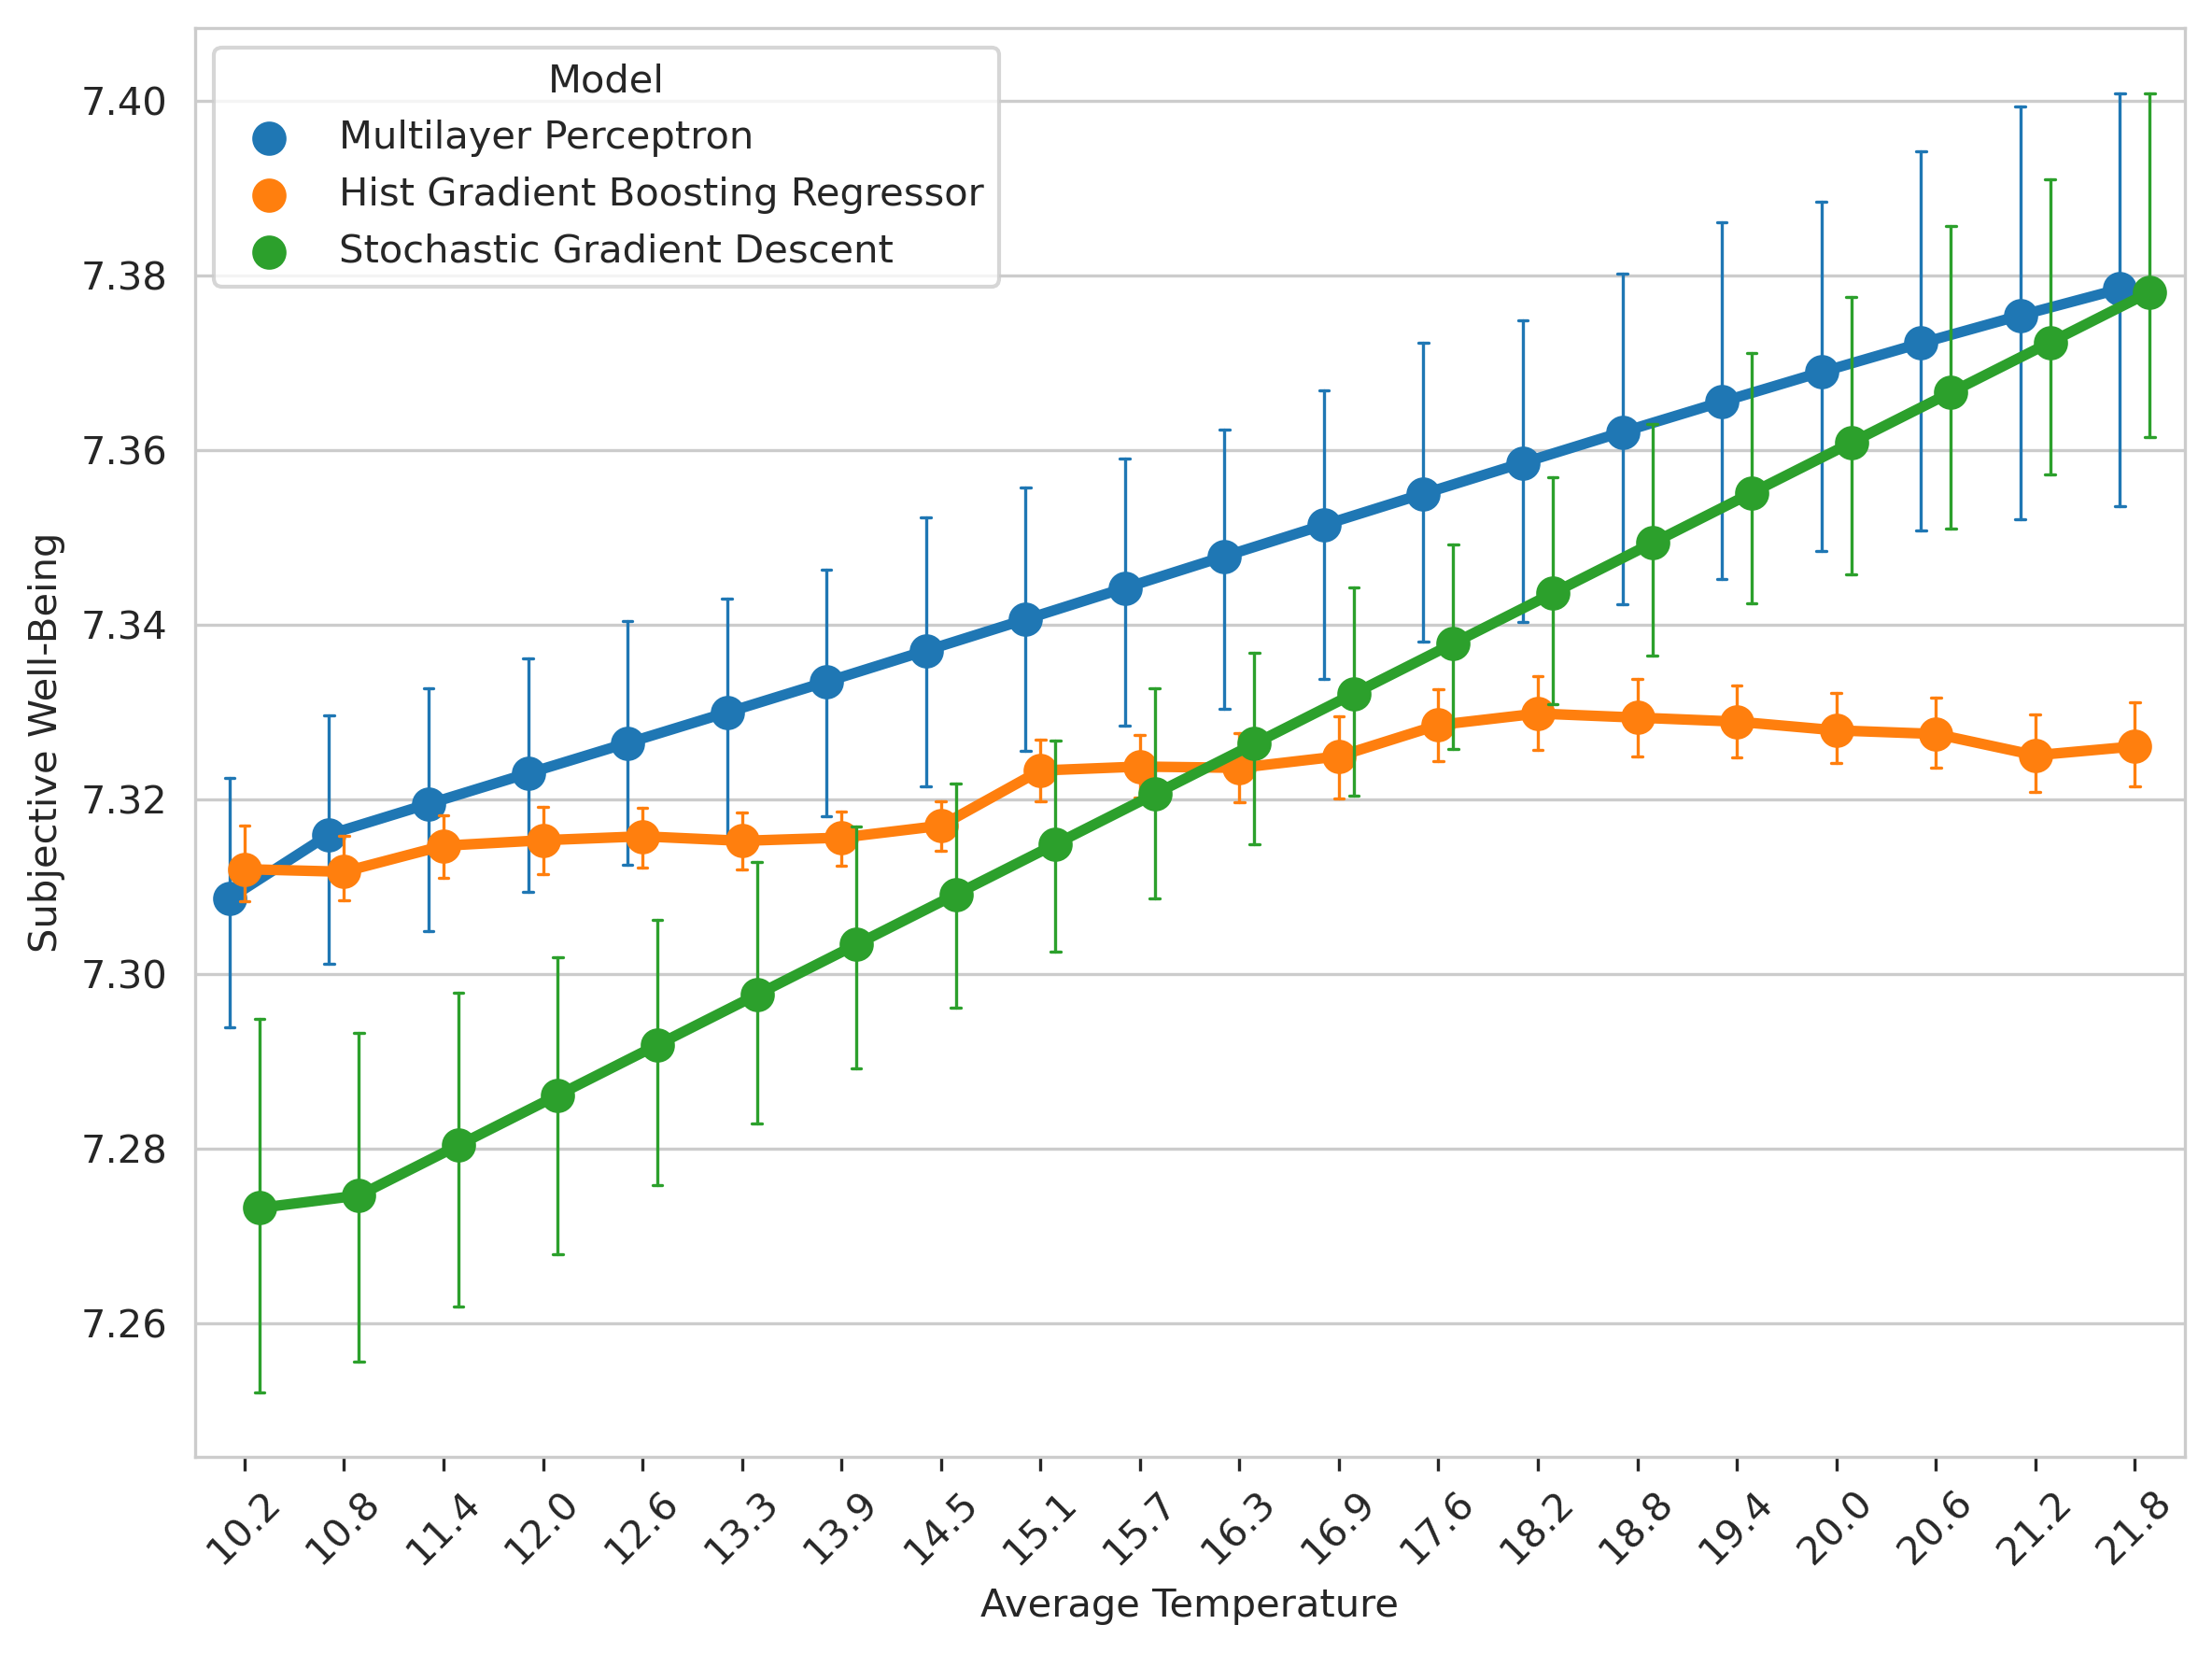

In [22]:
# Define number of bins
num_bins = 20

# Define bin edges
bin_edges = np.linspace(df_results['values'].min(), df_results['values'].max(), num_bins + 1)

# Create a new column 'bin' that assigns each 'values' entry to a bin
df_results['bin'] = pd.cut(df_results['values'], bins=bin_edges)

# Assign bin centers to 'bin_center' column
df_results['bin_center'] = df_results['bin'].apply(lambda x: x.mid)

temp = np.zeros((df_results.shape[0], 5)) # 5 weather variables
temp[:, -1] = df_results['bin_center'].values
bin_center_transformed = transformer.named_transformers_['Weather'].inverse_transform(temp)[:,-1]

df_results['bin_center'] = np.round(bin_center_transformed, 1)

# Plot with seaborn pointplot for each model
plt.figure(figsize=(8, 6), dpi=300)
sns.pointplot(data=df_results, x='bin_center', y='average', hue='model', join=True, capsize=.1, dodge=0.3, errwidth=0.8)
# Get the legend and modify the title
legend = plt.legend()
legend.set_title('Model')

# Other settings (rotating x-labels, adding x-ticks, etc.)
plt.xticks(rotation=45)
plt.tick_params(axis='x', which='both', bottom=True, top=False)
plt.xlabel('Average Temperature')
plt.ylabel('Subjective Well-Being')

# Save the plot
plt.tight_layout()
plt.savefig(f'{base_path}/effect_temperature.pdf', dpi=300)

In [16]:
"""
from collections import defaultdict

store = defaultdict(list)
for model, r1, r2 in partial_dependence_results:
    _, scaler, index = transformer.transformers_[-1]
    i = np.where(index == 'tavg')[0][0]

    x1 = np.round(r1['values'][0], 2)
    y1 = r1['values'][1]
    z1 = r1['average'].squeeze()
    temp_array = np.zeros((len(y1), len(index)))
    temp_array[:, i] = y1
    y1_rescaled = np.round(scaler.inverse_transform(temp_array)[:, i], 2)

    x2 = np.round(r2['values'][0], 2)
    y2 = r2['values'][1]
    z2 = r2['average'].squeeze()
    temp_array = np.zeros((len(y2), len(index)))
    temp_array[:, i] = y2
    y2_rescaled = np.round(scaler.inverse_transform(temp_array)[:, i], 2)

    store[model].append((x1, y1_rescaled, z1, x2, y2_rescaled, z2))


fig, axs = plt.subplots(4, len(models), figsize=(18, 16))
for i, (model, arrays) in enumerate(store.items()):
    data = list(zip(*arrays))  # Transpose the list of arrays
    x1, y1, z1, x2, y2, z2 = [np.mean(d, axis=1).round(2) for d in data]
    _, _, z1_std, _, _, _ = [np.std(d, axis=1).round(2) for d in data]
    _, _, _, _, _, z2_std = [np.std(d, axis=1).round(2) for d in data]

    for idx, (x, y, z, z_std) in enumerate([(x1, y1, z1, z1_std), (x2, y2, z2, z2_std)]):
        df_mean = pd.DataFrame(data=z, columns=x, index=y)
        df_std = pd.DataFrame(data=z_std, columns=x, index=y)
        sns.heatmap(df_mean, ax=axs[i, 2*idx])
        sns.heatmap(df_std, ax=axs[i, 2*idx + 1])

plt.show()
"""

"\nfrom collections import defaultdict\n\nstore = defaultdict(list)\nfor model, r1, r2 in partial_dependence_results:\n    _, scaler, index = transformer.transformers_[-1]\n    i = np.where(index == 'tavg')[0][0]\n\n    x1 = np.round(r1['values'][0], 2)\n    y1 = r1['values'][1]\n    z1 = r1['average'].squeeze()\n    temp_array = np.zeros((len(y1), len(index)))\n    temp_array[:, i] = y1\n    y1_rescaled = np.round(scaler.inverse_transform(temp_array)[:, i], 2)\n\n    x2 = np.round(r2['values'][0], 2)\n    y2 = r2['values'][1]\n    z2 = r2['average'].squeeze()\n    temp_array = np.zeros((len(y2), len(index)))\n    temp_array[:, i] = y2\n    y2_rescaled = np.round(scaler.inverse_transform(temp_array)[:, i], 2)\n\n    store[model].append((x1, y1_rescaled, z1, x2, y2_rescaled, z2))\n\n\nfig, axs = plt.subplots(4, len(models), figsize=(18, 16))\nfor i, (model, arrays) in enumerate(store.items()):\n    data = list(zip(*arrays))  # Transpose the list of arrays\n    x1, y1, z1, x2, y2, z2 = [